In [1]:
%cd ..

/Users/clement/FactorExe


In [2]:
import functools

import jax
import jax.numpy as jnp
import numpy as np

from env import C_VPR

In [4]:
env = C_VPR(input_length=100)
keys = jax.random.split(jax.random.PRNGKey(0), 10)
examples, targets = jax.vmap(functools.partial(env.sample_n_hops, num_hops=30, return_target=True))(keys)

In [5]:
examples[:, -10:]

Array([[44, 28, 99, 47, 62, 92, 43, 87, 43, 85],
       [91, 92, 99, 81, 10, 78, 67, 12,  6, 85],
       [91, 53, 57, 66, 60, 57, 21, 75, 11, 77],
       [94, 73, 71, 26, 99, 10, 54, 19, 33, 37],
       [12, 92, 94, 16, 99, 79,  0, 47, 53, 79],
       [94, 15,  2, 39, 68,  7, 97, 67, 14, 92],
       [95, 24, 45, 11, 49, 56, 51, 23, 38, 20],
       [ 0, 82, 57, 27, 70, 52, 97, 99, 11, 90],
       [75, 47, 40, 48, 62, 96, 18, 98, 19,  0],
       [33, 70, 98, 48, 48, 50, 31, 19,  8, 96]], dtype=int32)

In [6]:
targets

Array([85, 85, 53, 37, 79, 67, 49, 90, 18,  8], dtype=int32)

In [7]:
examples[2]

Array([ 3, 52, 90,  5, 62,  8, 99, 95, 11, 98, 35, 14, 41,  1, 18, 51, 52,
       65, 22, 14, 96, 13, 29, 70, 92, 32, 83, 63,  1, 31, 31, 37, 30,  8,
       69, 14, 36, 38, 49, 15, 40, 90, 83, 47, 61, 35, 82, 87, 62, 53, 33,
       88,  5, 55, 43, 56, 57, 58, 59, 64, 69, 70, 36, 21, 66, 29, 70, 10,
       63, 38, 72, 11, 77, 93, 56, 14, 57, 78, 81, 31, 10, 83, 48, 84, 88,
       32, 63, 31, 90, 40, 91, 53, 57, 66, 60, 57, 21, 75, 11, 77],      dtype=int32)

In [8]:
key = jax.random.PRNGKey(0)
batch_size = 8
train_num_hops = [1, 2, 3, 4]
num_hops_key, sample_key, dropout_key = jax.random.split(key, 3)

def sample_n_hops(key, num_hops_index):
    if len(train_num_hops) == 1:
        del num_hops_index
        return env.sample_n_hops(
            key, train_num_hops[0], return_target=True
        )
    else:
        return jax.lax.switch(
            num_hops_index,
            [
                functools.partial(
                    env.sample_n_hops,
                    num_hops=num_hops,
                    return_target=True,
                )
                for num_hops in train_num_hops
            ],
            key,
        )

num_hops_indices = jax.random.choice(
    num_hops_key,
    jnp.arange(len(train_num_hops)),
    (batch_size,),
    replace=True,
)
sample_keys = jax.random.split(sample_key, batch_size)
examples, labels = jax.vmap(sample_n_hops)(sample_keys, num_hops_indices)


In [9]:
examples

Array([[18, 75, 57, 80, 40, 84, 73, 35, 65, 87,  3, 25, 73, 34,  2, 11,
        89, 92, 54, 20, 43, 63, 35, 74, 73, 65, 28, 89, 95, 13, 17, 71,
         1, 43, 27, 77, 15, 50, 19, 35, 35, 64, 11, 50, 22, 27, 85, 95,
         6,  6, 20, 78, 95, 43, 66, 22, 90, 10,  8, 95, 25, 22, 75, 54,
        30, 55, 68, 64, 58, 32, 16,  9, 46, 98, 56, 50, 68, 78,  5, 29,
        69, 32, 23, 45, 66, 82, 11, 50, 95, 53, 41, 81, 28, 83, 29, 60,
        35, 87,  2, 97],
       [38, 10, 80, 98,  4, 25, 56, 71, 97, 65, 62, 39, 96,  2, 62, 66,
        92, 76, 56, 64, 97, 71, 46, 31, 97, 86, 41, 15, 37, 45, 29, 35,
        44, 73, 81,  9, 92, 53, 24, 84,  7, 36, 77, 67, 46, 93, 52, 46,
        71, 57, 83, 45, 68, 67, 17,  8, 68,  6, 81, 11,  2, 22, 64,  3,
        83, 83, 62,  1, 32, 45,  2, 28, 38, 45, 33, 12, 77, 13, 68, 74,
         1, 80, 19, 82, 31, 86, 45, 59, 13, 34, 47, 95,  5, 15,  0, 47,
        98, 67, 48, 47],
       [32, 69, 20, 44, 81, 20, 46, 95, 21, 89, 42,  3, 12, 26, 59, 30,
        74, 50

In [10]:
labels

Array([58, 24, 52, 74, 14, 25, 32,  6], dtype=int32)

In [42]:


import jax
import wandb

from models import TransformerConfig, Transformer
from env import C_VPR
from train import Trainer

def get_model(
    run_name: str,
    train_num_hops: int | list[int] = 3,
    eval_num_hops: int | list[int] | None = None,
    seq_length: int = 10,
    num_layers: int = 2,
    num_repeat_model: int = 1,
    emb_dim: int = 384,
    num_heads: int = 6,
    mlp_dim_factror: float = 4,
    dropout_rate: float = 0.0,
    learning_rate: float = 5e-4,
    batch_size: int = 5,
    eval_size: int = 5,
    use_bias: bool = False,
    activation: str = "silu",
):
    config = TransformerConfig(
        vocab_size=seq_length,
        output_vocab_size=seq_length,
        emb_dim=emb_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        num_repeat_model=num_repeat_model,
        mlp_dim_factror=mlp_dim_factror,
        max_len=seq_length,
        dropout_rate=dropout_rate,
        attention_dropout_rate=dropout_rate,
        use_bias=use_bias,
        activation=activation,
    )
    model = Transformer(config)
    c_vpr = C_VPR(seq_length)

    trainer = Trainer(
        c_vpr, train_num_hops, eval_num_hops, seq_length, batch_size, eval_size
    )
    key = jax.random.PRNGKey(0)
    state = trainer.init_train_state(model, key, learning_rate)
    wandb.init()
    state = trainer.load_checkpoint("checkpoint.msgpack", state, run_name)
    return model, state

models, states = [], []
for num_layers in [1, 2, 3]:
    model, state = get_model(run_name=f"diff30-100num_layers{num_layers}", train_num_hops=30, seq_length=100, num_layers=num_layers)
    models.append(model)
    states.append(state)



INFO:root:Number of parameters: 1,885,824


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb:   1 of 1 files downloaded.  
INFO:root:Number of parameters: 3,656,064


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb:   1 of 1 files downloaded.  
INFO:root:Number of parameters: 5,426,304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Downloading large artifact diff30-100num_layers3--checkpoint:latest, 62.10MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.8


In [61]:
env = C_VPR(input_length=100)
keys = jax.random.split(jax.random.PRNGKey(0), 1000)
examples, targets = jax.vmap(functools.partial(env.sample_n_hops, num_hops=30, return_target=True))(keys)
examples[:10, -10:], targets[:10]

(Array([[92, 84, 95, 64, 57, 98, 91, 85,  8,  1],
        [92, 95, 44, 13, 91, 97, 88, 98, 99, 51],
        [37, 35, 94, 85, 36, 83, 12, 22, 44, 27],
        [32, 95, 28, 27, 54,  0, 63, 94, 74, 43],
        [93, 48, 93, 99, 54, 43, 28, 75,  5, 29],
        [93, 16, 80, 94, 85, 12, 96, 13, 46, 54],
        [ 8,  7, 28, 57, 76, 88, 84, 61, 74, 29],
        [96, 74, 79, 14, 19, 23, 75, 95,  1,  9],
        [34, 93, 98, 97, 78, 35, 70, 98, 70, 99],
        [93, 64, 83, 96, 25, 26, 88, 13,  7, 12]], dtype=int32),
 Array([ 8, 51, 36, 74, 29, 85, 84, 75, 70, 88], dtype=int32))

In [62]:
logits = [
    state.apply_fn(
        {"params": state.params},
        inputs=examples,
        deterministic=True,
    )
    for state in states
]
logits[0].shape

(1000, 100)

In [73]:
for i in range(3):
    errors = np.where((logits[i].argmax(axis=1) == targets) == False)[0]
    num_errors = len(errors)
    print(f"{i} layer(s):", num_errors, "error(s)", errors)
    

0 layer(s): 41 error(s) [ 33  39  48  69 125 162 169 171 195 207 226 300 312 322 371 446 503 515
 516 522 542 548 550 569 582 607 608 623 695 732 739 770 773 790 899 930
 936 944 955 971 997]
1 layer(s): 5 error(s) [ 69 472 548 550 930]
2 layer(s): 4 error(s) [118 379 548 770]


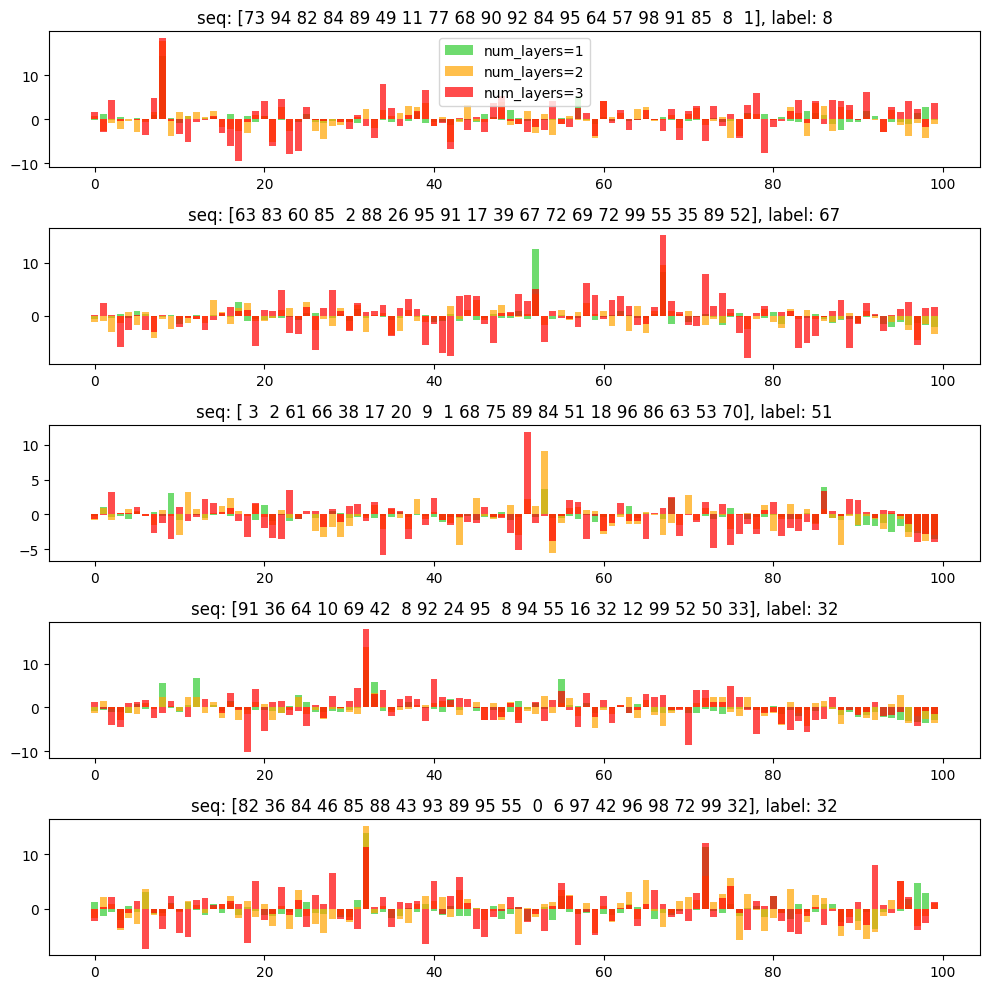

In [82]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))
for i, ax in zip([0, 33, 69, 530, 118], axes):
    for j, color in enumerate(reversed(["limegreen", "orange", "red"])):
        ax.bar(range(100), logits[j][i], color=color, label=f"num_layers={j+1}", alpha=0.7)
    ax.set_title(f'seq: {examples[i, -20:]}, label: {targets[i]}')
axes[0].legend(loc="upper center")
plt.tight_layout()
plt.show()
